# Bayesian Inference for Data Quality assurance

Author: Kenichi Maeda

## Bayes Theorem and Bayesian Updating

#### Conditional probability

Conditional probability is probability of a certain event occurring given that another certain event has occurred.
Probability of event A conditioned on B is denoted by P(A|B). Be aware of joint probability P(A,B), which is the probability of two events A and B occur together. Definition is:

\begin{equation}
P(A|B) = \frac{P(A,B)}{P(B)}
\end{equation}

#### Bayese Theorem

From the above definition and commutativity of joint probability P(B,A) = P(A,B)

\begin{equation}
P(A|B) = \frac{P(A,B)}{P(B)} = \frac{P(B|A)P(A)}{P(B)}
\end{equation}

This is called Bayes Theorem.

#### Bayesian updating

Bayesian approach sees probability as observer's confidence (subjective probability), and put Bayes Theorem as the basis for all calculation. According to Bayesian Inference, one has a current state of confidence (a priori/prior probability), and then update his confidence everytime he achieves new information (Data). The updated confidence is called a posteriori/posterior probability, and this process is called Bayesian updating.

Now given that we have a certain hypothesis H in our mind with a priori probability P(H), we update our confidence upon a new data D to a posteriori probability P(H|D) according to Bayes Thorem:

\begin{equation}
P(H|D) = \frac{P(D|H)P(H)}{P(D)}
\end{equation}

Here the conditional probability P(D|H) on the right hand side is likelihood of data D when hypothesis H is true. The denominator P(D) is the total probability of data D occuring for all scenarios. That is, it is calculated as

\begin{equation}
P(D) = P(D|H)P(H) + P(D|\neg H)P(\neg H)
\end{equation}

#### Application of Bayesian updating to data accuracy assurance

We can apply this method to evaluate how much we can trust our data, especially those simple and categorical, e.g. headquarters, founded year.

To sum up our situation, we have a certain information (e.g. HQ) for some company (e.g. "AtomLeap") from a few sources (e.g. webpage of a startup event, business news, company's official website). Since any source is not 100% reliable and our scraper does't always work accurately, we are not sure if the obtained information is correct. And the biggest problem is, sometimes (often) they do not agree to one another (e.g. for HQ of AtomLeap, source A says "Berlin", whereas source B says "Cologne").

**Suppose that we know the probability of each source giving correct information** (the central part of this project, we will come back to this later), this probability can be used as the likelihood $P(D|H)$ in Bayesian updating formula. If we obtain a certain information $H$ from a source with $90$% accuracy, then we start with a priori probability $P(H) = 90$. Then everytime we get a new data from different sources, depending whether it agrees with it ($H$) or not ($\neg H$), we update our confidence for this hypothesis H based on the Bayesian formula.

## Implement Bayesian Updating algorithm

In [1]:
class BayesianInference:
    def __init__(self, beliefs=None):
        self.beliefs = beliefs or dict()      #candidates and our confidences for them
        self.history = []      #record of observations
    
    def update(self, src, observation):
        reliability = data[src].get('reliability')     #probability of each source giving the correct information. Need to be given by independent investigations
        
        def likelihood(src, positive_observation:bool):     #conditional probability
            if  positive_observation:
                l = reliability
            else:
                l = 1 - reliability
            return l
        def total_prob(apriori, likelihood):     #denominator of the Bayes theorem
            p = likelihood*apriori + (1-likelihood)*(1-apriori)
            return p
        
        for hypothesis, apriori in self.beliefs.items():         #update confidences of values already observed
            positive_observation = (observation == hypothesis)
            l = likelihood(src, positive_observation)
            p = total_prob(apriori, l)
            aposteriori = l*apriori/p
            self.beliefs.update({hypothesis: aposteriori})
        if observation not in self.beliefs.keys():       #If the value has never been observed, calculate its confidence and add as a new condidate.
            apriori = reliability
            for entry in self.history:
                l = likelihood(entry['source'], False)
                p = total_prob(apriori, l)
                apriori = l*apriori/p
            aposteriori = apriori
            self.beliefs.update({observation: aposteriori})
        self.history.append({'source': src, 'result': observation})
    
    """
    Return the value with the highest confidence at the moment
    """
    def estimate(self):
        best_hypothesis = max(self.beliefs, key=self.beliefs.get)
        confidence = self.beliefs[best_hypothesis]
        return best_hypothesis, confidence

## Generate examples of data from multiple imperfect sources

You can simulate Bayesian Updating with the following code.

In [2]:
from numpy.random import choice

"""
Choose all source grades and their reliability. These have to be given from actual investigations.
"""
src_grades = {'A': 0.9, 'B': 0.8, 'C': 0.7, 'D': 0.6}

"""
Randomly generate a single observation. Specify the reliability of the source and choices of outcomes.
Put the true value as the first entity of 'candidates'.
"""
def generate_observation(reliability, candidates:list):
    weights = [reliability] + [(1-reliability)/(len(candidates)-1)]*(len(candidates)-1)
    draw = choice(candidates, p=weights)
    return draw

"""
Simulate a set of observations from the above code. Specify number of observations and choices of outcomes. 
You can also change percentage of source grades. If not specified, each grade of sources appear evenly.
"""
def generate_data_example(num, candidates, src_grade_weights=None):
    data = dict()
    src_list = choice(list(src_grades.keys()), size=num, p=src_grade_weights)
    for i in range(0, num):
        reliability = src_grades[src_list[i]]
        observation = generate_observation(reliability, candidates)
        src_label = f'S{i+1}'
        data[src_label] = {'reliability': reliability, 'observation': observation}
    return data

In [3]:
data = generate_data_example(10, ['Berlin', 'Cologne', 'Munich'])
data

{'S1': {'reliability': 0.8, 'observation': 'Berlin'},
 'S2': {'reliability': 0.6, 'observation': 'Berlin'},
 'S3': {'reliability': 0.9, 'observation': 'Berlin'},
 'S4': {'reliability': 0.7, 'observation': 'Berlin'},
 'S5': {'reliability': 0.7, 'observation': 'Berlin'},
 'S6': {'reliability': 0.7, 'observation': 'Munich'},
 'S7': {'reliability': 0.6, 'observation': 'Munich'},
 'S8': {'reliability': 0.7, 'observation': 'Berlin'},
 'S9': {'reliability': 0.6, 'observation': 'Cologne'},
 'S10': {'reliability': 0.8, 'observation': 'Berlin'}}

In [26]:
#One good example for simulation
"""
data = {
    'S1': {'reliability': 0.6, 'observation': 'Cologne'},
    'S2': {'reliability': 0.6, 'observation': 'Berlin'},
    'S3': {'reliability': 0.8, 'observation': 'Munich'},
    'S4': {'reliability': 0.6, 'observation': 'Berlin'},
    'S5': {'reliability': 0.7, 'observation': 'Berlin'},
    'S6': {'reliability': 0.9, 'observation': 'Berlin'},
    'S7': {'reliability': 0.8, 'observation': 'Berlin'},
    'S8': {'reliability': 0.9, 'observation': 'Berlin'},
    'S9': {'reliability': 0.6, 'observation': 'Munich'},
    'S10': {'reliability': 0.7, 'observation': 'Munich'}
}
"""

## Simulate Bayesian Updating

In [4]:
import matplotlib.pyplot as plt

In [5]:
data_iter = iter(data)

In [6]:
bayesian = BayesianInference()

Visually demonstrate accumulated confidence. Run the next function repeatedly!

In [7]:
def simulate(data_iter:iter):   #input data as iterator
    src = next(data_iter)

    fig = plt.figure()

    observation = data[src]['observation']
    bayesian.update(src, observation)
    print(f'Update with {src}: {observation}')
    beliefs = bayesian.beliefs
    print(f'Hypothesis and confidence: {beliefs}')
    fig.clf()
    plt.bar(beliefs.keys(), beliefs.values())
    return

Update with S10: Berlin
Hypothesis and confidence: {'Berlin': 0.9980903882877149, 'Munich': 0.003601547331446105, 'Cologne': 0.014420910319963964}


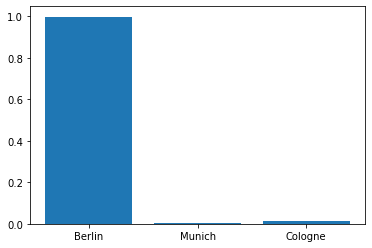

In [17]:
simulate(data_iter)

In [18]:
bayesian.history

[{'source': 'S1', 'result': 'Berlin'},
 {'source': 'S2', 'result': 'Berlin'},
 {'source': 'S3', 'result': 'Berlin'},
 {'source': 'S4', 'result': 'Berlin'},
 {'source': 'S5', 'result': 'Berlin'},
 {'source': 'S6', 'result': 'Munich'},
 {'source': 'S7', 'result': 'Munich'},
 {'source': 'S8', 'result': 'Berlin'},
 {'source': 'S9', 'result': 'Cologne'},
 {'source': 'S10', 'result': 'Berlin'}]

In [19]:
bayesian.estimate()

('Berlin', 0.9980903882877149)

## Reliability of each source

As mentioned earlier, it is crucial for this approach to know the reliability of each source. Considering we have to use so many different sources, it is unrealistic to establish some predictive model to estimate it. So I would like to propose to classify sources into a several types and at least assign reliability to each of those types. Then we can **investigate the reliability of each source type by comparing our data to some data that we can believe (at least almost) certainly correct.**

#### Source types

I propose the following source types.

1. Official websites
2. Annual reports
3. Company list webpages (e.g. startup list)
4. Texts (e.g. news articles)
5. Company profile page of data platforms (one company in one page)
6. Wikipedia
7. Crunchbase
8. Manual

Probably we have to implement a source type classifier for 3, 4, 5 (not page classifier)

Or if the classification is difficult, we can just assign the same reliability to all sources.

## Data gathering

Another benefit of this method is that now we don't have to be worried about the quality of each source/scraping so much anymore. We can just confirm data with as many sources as possible, and no matter how bad each source is, we will reach the correct information at some point.

Until now, our data acquisition paradigm has been passive. We collected information from given data sources, and therefore for many minor companies we only have confirmation from a single source. Instead, I suggest active data acquisition, that is, crawling web and use random sources there for specific data. In the example of AtomLeap's HQ, if you google "AtomLeap headquarters" then you will see a lot of pages mentioning this information. We just need to jump in each page and collect the corresponding part until our confidence for this information to be satisfactory high (>98%?).